In [9]:
%matplotlib inline

import copy
import datetime as dt
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
from joblib import Parallel, delayed
from sklearn.model_selection import cross_val_score
from skopt import gp_minimize, Optimizer
from skopt.space import Space, Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_evaluations, partial_dependence, plot_objective

In [10]:
features = ['Pclass', 'Title', 'Age', 'Fam_type', 'Fare', 'Embarked']#, 'Cabin_info']#, 'Deck', 'Sex']
cat_features = ['Pclass', 'Title', 'Sex', 'Fam_type', 'Embarked', 'Deck', 'Cabin_info']

In [11]:
df_train = pd.read_csv(os.path.join('data', 'train.csv'), index_col=0)
df_test = pd.read_csv(os.path.join('data', 'test.csv'), index_col=0)

# Because of the amount of missing values and high number of categories, Deck is probably a bad feature
df_train['Deck'] = df_train['Cabin'].dropna().str[0]
df_test['Deck'] = df_test['Cabin'].dropna().str[0]
# New binary cabin feature
df_train['Cabin_info'] = df_train['Cabin'].apply(lambda x: 1 if x is not np.nan else 0)
df_test['Cabin_info'] = df_test['Cabin'].apply(lambda x: 1 if x is not np.nan else 0)

# Pro tips from Massimiliano Viola's kernel
df_train.loc[(df_train['Fare']==0), 'Fare'] = np.nan
df_test.loc[(df_test['Fare']==0), 'Fare'] = np.nan

# Combine siblings, spouses, parents and children into a family size feature
df_train['Fam_type'] = pd.cut(df_train['SibSp'] + df_train['Parch'] + 1, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])
df_test['Fam_type'] = pd.cut(df_test['SibSp'] + df_test['Parch'] + 1, [0,1,4,7,11], labels=['Solo', 'Small', 'Big', 'Very big'])

# Create Title feature based on name (replaces Sex as feature)
df_train['Title'] = df_train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df_test['Title']  = df_test['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
df_train['Title'] = df_train['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss')
df_test['Title']  = df_test['Title'].replace(['Mme', 'Ms', 'Lady', 'Mlle', 'the Countess', 'Dona'], 'Miss')
df_train['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)
df_test['Title'].replace(['Major', 'Col', 'Capt', 'Don', 'Sir', 'Jonkheer'], 'Mr', inplace=True)

In [12]:
for feature in cat_features:
    df_train[feature] = df_train[feature].astype('category')
    df_test[feature] = df_test[feature].astype('category')
    
X = df_train[features]
y = df_train['Survived']

In [13]:
space = [
    Integer(2, 1023, name='num_leaves'),
#     Real(0.001, 0.1, 'log-uniform', name='lr'),
    Integer(10, 1000, name='n_estimators'),
    Integer(1, 100, name='min_data'),
    Real(0.1, 1.0, name='colsample_bytree')
]

guess = [63, 300, 10, 0.5]

@use_named_args(space)
def objective(**opt_params):
    lgb_params = {
        'num_leaves': opt_params['num_leaves'],
        'max_depth': -1,
        'learning_rate': 0.01, #opt_params['lr'],
        'n_estimators': opt_params['n_estimators'],
        'min_child_samples': opt_params['min_data'],
        'colsample_bytree': opt_params['colsample_bytree'],
        'sub_sample': 1.0,
        'subsample_freq': 0,
        'random_seed': 1234
    }
            
    clf = lgb.LGBMClassifier(**lgb_params)
    return -cross_val_score(clf, X, y, cv=5).mean()

In [14]:
optimizer = Optimizer(
    dimensions=space,
    n_initial_points=10, # Will round up to even number of jobs (10 => 12)
    random_state=1234,
    base_estimator='gp'
)

n_observations = 200
n_cores = 4

# Do initial guess
yy = objective(guess)
results = optimizer.tell(guess, yy)

for i in range(int(n_observations/n_cores)):
    start_time = time.time()
    xx = optimizer.ask(n_points=n_cores)  # x is a list of n_points points
    print(f'Ask time {time.time()-start_time:.1f}s')
    yy = Parallel(n_jobs=n_cores)(delayed(objective)(v) for v in xx)  # evaluate points in parallel
    print(f'Ask+job time {time.time()-start_time:.1f}s')
    results = optimizer.tell(xx, yy)
    
    idx = np.argmin(results['func_vals'])
    print(f'Iteration {i:3d} timed {time.time()-start_time:.1f}s with best-so-far accuracy {-1*results["func_vals"][idx]:.3f} with x={results["x_iters"][idx]}')
# results

Ask time 0.0s
Ask+job time 4.7s
Iteration   0 timed 4.7s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 0.0s
Ask+job time 1.6s
Iteration   1 timed 1.6s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 1.1s
Ask+job time 24.0s
Iteration   2 timed 24.4s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 2.0s
Ask+job time 2.6s
Iteration   3 timed 3.0s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 2.4s
Ask+job time 3.2s
Iteration   4 timed 3.6s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 2.5s
Ask+job time 12.0s
Iteration   5 timed 12.5s with best-so-far accuracy 0.841 with x=[626, 624, 45, 0.6230594858650789]
Ask time 2.8s
Ask+job time 4.9s
Iteration   6 timed 5.4s with best-so-far accuracy 0.842 with x=[782, 1000, 42, 0.6372464428214565]
Ask time 3.1s
Ask+job time 5.6s
Iteration   7 timed 6.2s with best-so-far accu

C:\ProgramData\Anaconda3\envs\py38\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Ask time 10.6s
Ask+job time 12.7s
Iteration  29 timed 15.0s with best-so-far accuracy 0.842 with x=[782, 1000, 42, 0.6372464428214565]
Ask time 11.7s
Ask+job time 15.5s
Iteration  30 timed 18.0s with best-so-far accuracy 0.842 with x=[782, 1000, 42, 0.6372464428214565]
Ask time 14.3s
Ask+job time 19.0s
Iteration  31 timed 22.0s with best-so-far accuracy 0.842 with x=[782, 1000, 42, 0.6372464428214565]
Ask time 12.8s
Ask+job time 15.2s
Iteration  32 timed 17.9s with best-so-far accuracy 0.847 with x=[1023, 547, 40, 0.6203793105671851]
Ask time 13.0s
Ask+job time 15.9s
Iteration  33 timed 18.7s with best-so-far accuracy 0.847 with x=[1023, 547, 40, 0.6203793105671851]
Ask time 15.8s
Ask+job time 16.7s
Iteration  34 timed 19.8s with best-so-far accuracy 0.847 with x=[1023, 547, 40, 0.6203793105671851]
Ask time 14.1s
Ask+job time 16.9s
Iteration  35 timed 19.7s with best-so-far accuracy 0.847 with x=[1023, 547, 40, 0.6203793105671851]
Ask time 15.1s
Ask+job time 19.2s
Iteration  36 timed 2

In [15]:
idx = np.argmin(results['func_vals'])
print('Winning parameters', results['x_iters'][idx], 'with Sharpe', -1*results['func_vals'][idx])
print()
print(results)

Winning parameters [1023, 547, 40, 0.6203793105671851] with Sharpe 0.84739815454146

          fun: -0.84739815454146
    func_vals: array([-0.82720482, -0.8294269 , -0.83730463, -0.8003013 , -0.84066286,
       -0.80251083, -0.83728579, -0.8238152 , -0.82831586, -0.81482016,
       -0.78899002, -0.81595003, -0.78569456, -0.61616345, -0.61616345,
       -0.61616345, -0.61616345, -0.78342226, -0.80138723, -0.80475174,
       -0.81033206, -0.83952671, -0.81815329, -0.79122466, -0.79800389,
       -0.81591865, -0.61616345, -0.61616345, -0.84178645, -0.78452702,
       -0.81591237, -0.83729207, -0.80809114, -0.77778545, -0.78565062,
       -0.82379637, -0.81034461, -0.82043814, -0.80138096, -0.80025736,
       -0.79689285, -0.78452075, -0.78452075, -0.78452075, -0.81706108,
       -0.81930827, -0.79688657, -0.78681815, -0.82043186, -0.8406503 ,
       -0.81255414, -0.79128115, -0.82716716, -0.83500722, -0.78681815,
       -0.81706108, -0.78681815, -0.83505116, -0.83727952, -0.83280397,
   

Best score=-0.84740
Best parameters=[1023, 547, 40, 0.6203793105671851]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B18A901F40>,
      dtype=object)

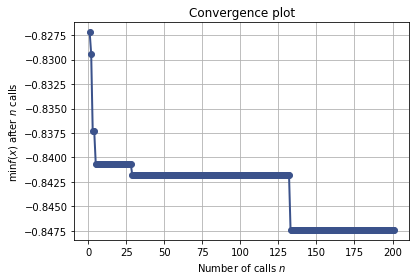

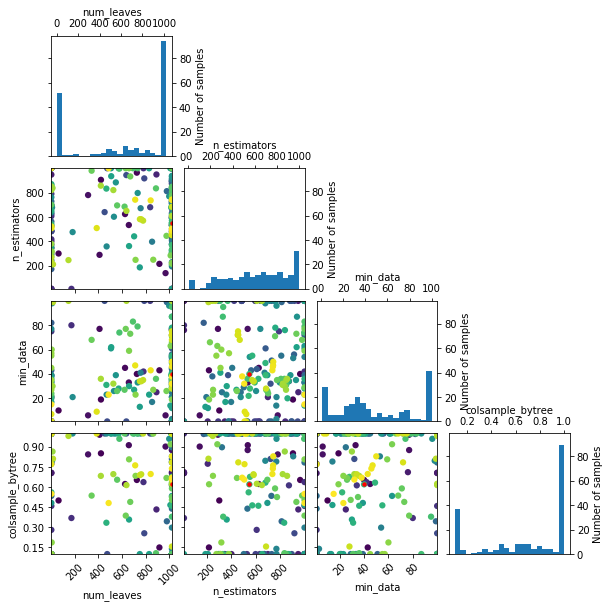

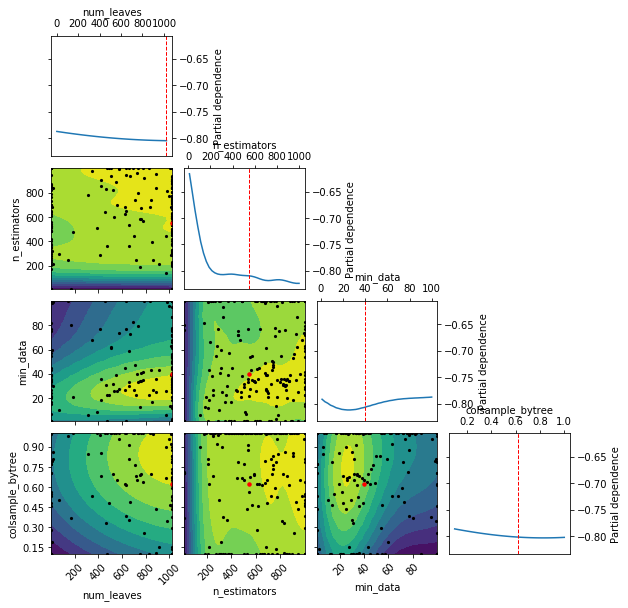

In [16]:
print('Best score={:.5f}'.format(results.fun))
print('Best parameters={}'.format(results.x))

plot_convergence(results)
plot_evaluations(results)
# partial_dependence(Space(space), results.models[0], 0)
plot_objective(results)
# results

Best score=-0.84401
Best parameters=[654, 1000, 38, 1.0]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002B18C10EA00>,
      dtype=object)

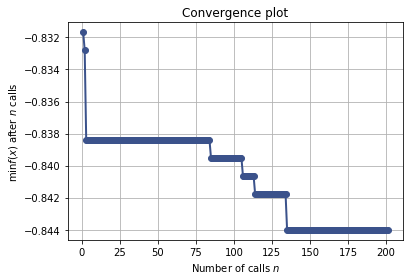

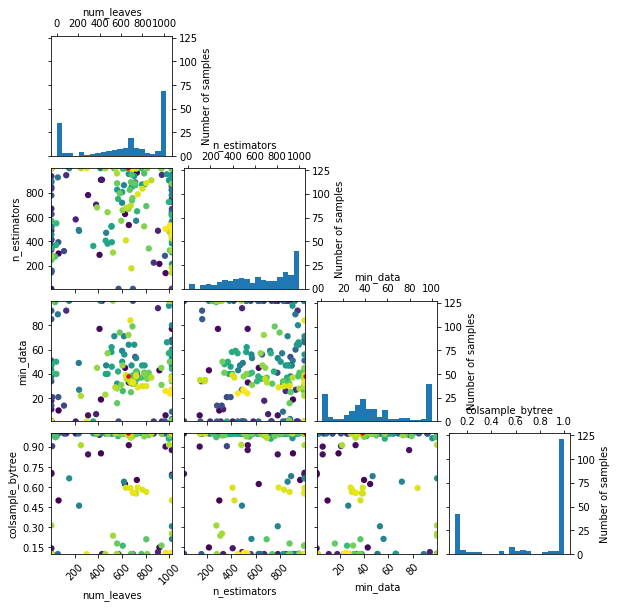

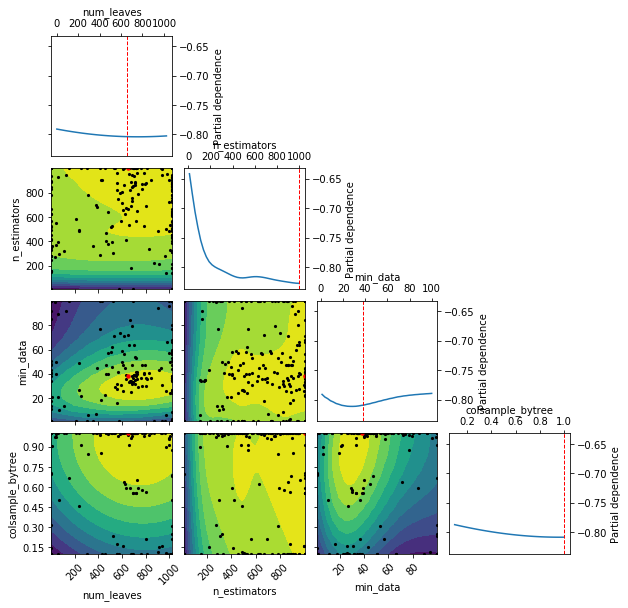

In [8]:
print('Best score={:.5f}'.format(results.fun))
print('Best parameters={}'.format(results.x))

plot_convergence(results)
plot_evaluations(results)
# partial_dependence(Space(space), results.models[0], 0)
plot_objective(results)
# results